In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import morphology
from skimage.segmentation import watershed
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from skimage.morphology import square
from scipy import ndimage
from PIL import Image, ImageOps
from largest_rect import get_largest_rect

In [81]:
img_test = np.zeros((15, 15))
img_test[2:5, 5:11] = 120 + np.random.randint(0, 5, [3, 6])
img_test[5:10, 9:14] = 120 + np.random.randint(0, 5, [5, 5])
img_test[5:13, 2:5] = 120 + np.random.randint(0, 5, [8, 3])

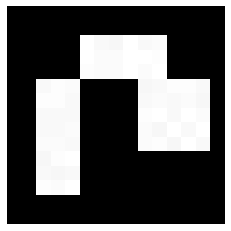

In [82]:
plt.imshow(img_test, cmap='gray')
plt.axis('off')
plt.show()

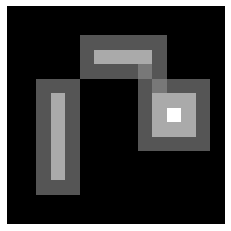

In [83]:
distance_t = ndimage.distance_transform_edt(img_test)
plt.imshow(distance_t, cmap='gray')
plt.axis('off')
plt.show()

In [88]:
img_rgb = Image.open("leaves.jpg")
img = ImageOps.grayscale(img_rgb)
img = np.asarray(img)
print(img.shape)

no_seeds = 5
random_seeds = np.zeros(img.shape)

# 2d nparray of random pixel positions (only with square)
# Might be much better to have non-random positions for watershed
indices = np.random.uniform(0, 1, (no_seeds, 2))
indices[:,0] = (indices[:,0] * img.shape[0])
indices[:,1] = (indices[:,1] * img.shape[1])
indices = indices.astype(int)

# indices = np.random.randint(0, img.shape[0], [no_seeds, 2])
random_seeds[indices[:,0], indices[:,1]] = img[indices[:,0], indices[:,1]]
random_seeds = morphology.dilation(random_seeds, square(min(img.shape) // 20)).astype(np.uint8)

(1200, 783)


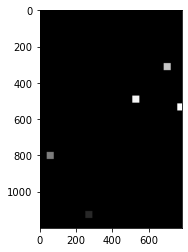

In [89]:
plt.imshow(random_seeds, cmap='gray')
plt.show()

In [90]:
# compute the img gradient = img_dilation - img_erosion
img_dil = morphology.dilation(img, morphology.disk(1)).astype(np.uint8)
img_ero = morphology.erosion(img, morphology.disk(1)).astype(np.uint8)
img_grad = img_dil - img_ero

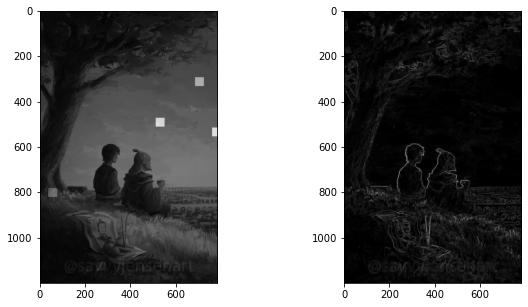

In [91]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(img, cmap='gray')
ax[0].imshow(random_seeds, cmap='gray', alpha=.5)
ax[1].imshow(img_grad, cmap='gray')

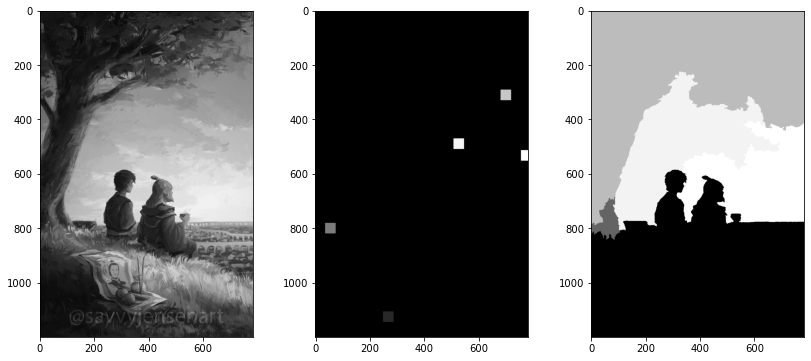

In [92]:
img_segment = watershed(img_grad, random_seeds, watershed_line=False)
fig, ax = plt.subplots(ncols=3, figsize=(14, 6))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(random_seeds, cmap='gray')
ax[2].imshow(img_segment, cmap='gray')

In [93]:
# Determine the size of the indivudal segmentations (there should be 20)
values, counts = np.unique(img_segment, return_counts=True)
seg_dict = dict(zip(values, counts))
print(seg_dict)

num_segments = 4
pixel_classes = []

for i in range(num_segments):
    pixel_key = max(seg_dict, key=seg_dict.get)
    print(seg_dict[pixel_key])
    seg_dict.pop(pixel_key)
    pixel_classes.append(pixel_key)
    
print(pixel_classes)

{29: 356013, 90: 8577, 144: 329101, 178: 138198, 185: 107711}
356013
329101
138198
107711
[29, 144, 178, 185]


29 279174
144 175950
178 54600
185 53295


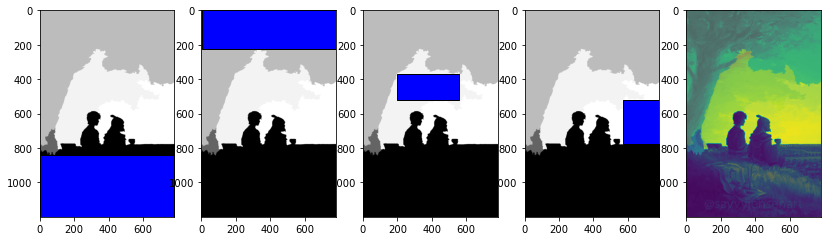

In [94]:
# Now we have the 5 largest segmentation cells from the original image
# Let's find the largest embedded square in each one and display them over img_segment

fig, ax = plt.subplots(ncols=num_segments + 1, figsize=(14, 6))
ax = ax.ravel()
for i in range(num_segments):
    ax[i].imshow(img_segment, cmap='gray')

for i, pixel_class in enumerate(pixel_classes):
    mask = (img_segment == pixel_class).astype(int)
    x0, x1, y0, y1, area = get_largest_rect(mask)
    ax[i].add_patch(patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=1,edgecolor='black',facecolor='blue'))
    print(pixel_class, area)
ax[num_segments].imshow(img)
ax[num_segments].imshow(img_segment, alpha=.5)
plt.show()    

In [11]:
# How to construct the actual image?
# We need to construct a video (4d tensor with shape: (t, c, h, w))
# in each frame, keep the static image and add the current moving pixels for each segment

# Image Segments Prototype
# For each segment in the collection:
    # Assumptions: each segment has a regular/expressible texture
    # Need to find the largest embedded square in the image to feed to vgg16
    # Don't scale the size of the embedded square of shape (z, z)
    # Run the external NCA package to compute local CA rules minimizing gram distance
    # Once near-optimal weights have been found, expand the size of the NCA to fill whole region
        # Is there a way to wrap the convolutions around the segmented areas?
        # Might be easier to simulate the entire rectangular region
            # Approx. 2x as slow
    # set the pixel values of the segmentation region for the current frame